### PREGUNTA 4

El archivo Web Server Requests G contiene un conjunto de datos que proporciona un registro histórico (sintético) de la tasa de llegada de solicitudes que un servidor web ha experimentado durante un intervalo de tiempo de 5 minutos. Esta información es esencial para comprender y gestionar la carga del servidor, planificar la infraestructura, y garantizar un rendimiento óptimo
en un entorno de servidor web real.
1. Identificar patrones de tráfico web como horas pico de actividad y momentos de menor demanda.
2. Ajuste una distribución gamma a sus datos de “Arrival Rate”, trace el histograma de sus datos junto con la función de densidad de probabilidad (pdf) de la distribución gamma ajustada y muestre los parámetros de la distribución gamma ajustada.
3. ¿Cuál es la probabilidad de que el servidor reciba más de 8 solicitudes durante el próximo intervalo?
4. ¿Cuál es la probabilidad de que la tasa de llegada supere un umbral crítico de, por ejemplo, 15 solicitudes por minuto, en el próximo intervalo?
5. Si la capacidad máxima de procesamiento del servidor es de 25 solicitudes por intervalo, ¿Cuál la probabilidad de superar la capacidad máxima de procesamiento del servidor en el siguiente intervalo?

#### Identificación de patrones de tráfico web

Para realizar un correcto análisis, generamos más columnas para el dataframe dado que existía más información detrás de la marca temporal de cada 5 minutos, con esta logramos identificar las horas, y los días de la semana para poder hacer un análisis más apropiado.

¿Cómo llegamos a esto?

Si cada registro se tomó en un lapso de 5 minutos eso significa que
* 1 registro = 5 minutos
* 12 registros = 1 hora
* 288 registros = 1 día
* 8640 registros = 1 mes

Teniendo esta información, podemos realizar análisis de tráfico en diferentes marcas temporales (horas al día y días a la semana)

In [9]:
#Obtener la información temporal
import pandas as pd

def rename_timestamp_column(df):
    """
    Renames the 'Timestamp' column to 'Minute'.

    Parameters:
    df (DataFrame): Input DataFrame.

    Returns:
    DataFrame: DataFrame with renamed column.
    """
    return df.rename(columns={'Timestamp': 'Minute'})

def calculate_hour_column(df):
    """
    Calculates the 'Hour' column based on the index.

    Parameters:
    df (DataFrame): Input DataFrame.

    Returns:
    DataFrame: DataFrame with 'Hour' column inserted.
    """
    df['Hour'] = (df.index // 12) % 24
    return df

def assign_weekday(df):
    """
    Assigns weekday to each row in the DataFrame.

    Parameters:
    df (DataFrame): Input DataFrame.

    Returns:
    DataFrame: DataFrame with 'Day' column inserted.
    """
    dias_semana = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    contador_dia = 0

    def asignar_dia(row_index):
        nonlocal contador_dia
        if row_index % 288 == 0:
            dia = dias_semana[contador_dia]
            contador_dia = (contador_dia + 1) % len(dias_semana)
            return dia
        else:
            return None

    df['Day'] = [asignar_dia(index) for index, _ in df.iterrows()]
    df['Day'] = df['Day'].ffill()
    return df

def assign_month(df):
    """
    Assigns weekday to each row in the DataFrame.

    Parameters:
    df (DataFrame): Input DataFrame.

    Returns:
    DataFrame: DataFrame with 'Month' column inserted.
    """
    meses = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
    contador_mes = 0

    def asignar_mes(row_index):
        nonlocal contador_mes
        if row_index % 8640 == 0:
            mes = meses[contador_mes]
            contador_mes = (contador_mes + 1) % len(meses)
            return mes
        else:
            return None

    df['Month'] = [asignar_mes(index) for index, _ in df.iterrows()]
    df['Month'] = df['Month'].ffill()
    return df

def organize_columns(df):
    """
    Organizes the columns of the DataFrame.

    Parameters:
    df (DataFrame): Input DataFrame.

    Returns:
    DataFrame: DataFrame with organized columns.
    """
    df['Hour'] = df['Hour'].astype(int)
    df = df[['Month','Day', 'Hour', 'Minute', 'Arrival_Rate']]
    return df

# Load the DataFrame here
df = pd.read_csv('../data/Web_Server_Requests_G.csv')

# ARREGLO DEL DATASET
df = rename_timestamp_column(df)
df = calculate_hour_column(df)
df = assign_weekday(df)
df = assign_month(df)
df = organize_columns(df)

# Print DataFrame columns
print("Ahora contamos con las siguientes nuevas columnas:",df.columns)
print("Puedes ver el nuevo archivo en la carpeta './data/output/'")

# Save the DataFrame to a new CSV file
df.to_csv('../data/output/Web_Server_Requests_G_(With_time_frames).csv', index=False)


Ahora contamos con las siguientes nuevas columnas: Index(['Month', 'Day', 'Hour', 'Minute', 'Arrival_Rate'], dtype='object')
Puedes ver el nuevo archivo en la carpeta './data/output/'


##### ¿Cuál es el promedio de la tasa de llegada de solicitudes para cada hora del día?

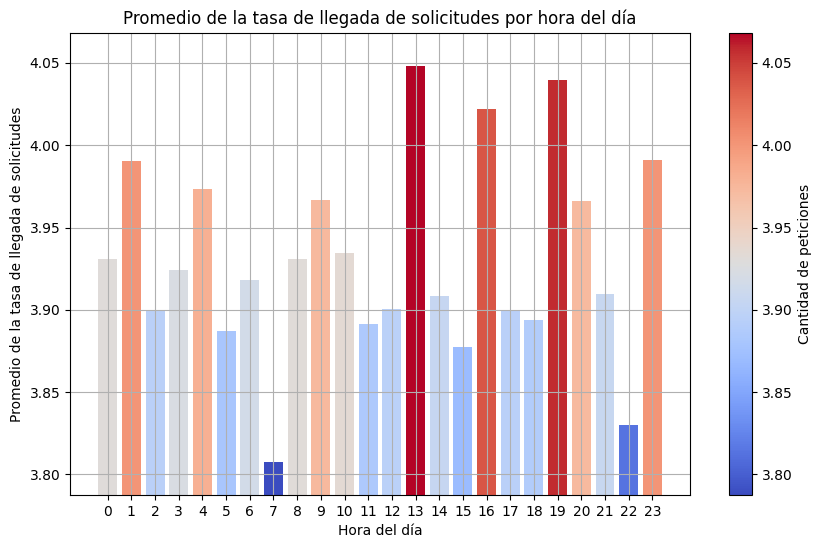

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Calcular la mediana de la tasa de llegada de solicitudes para cada hora del día
mean_request_rate_by_hour = df.groupby('Hour')['Arrival_Rate'].mean()

# Definir una escala de colores que vaya de azul a rojo, basada en los valores de la altura de las barras
colors = plt.cm.coolwarm((mean_request_rate_by_hour - mean_request_rate_by_hour.min()) / (mean_request_rate_by_hour.max() - mean_request_rate_by_hour.min()))

# Crear el gráfico de barras con colores graduales
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(mean_request_rate_by_hour.index, mean_request_rate_by_hour.values, color=colors)

# Añadir título y etiquetas
ax.set_title('Promedio de la tasa de llegada de solicitudes por hora del día')
ax.set_xlabel('Hora del día')
ax.set_ylabel('Promedio de la tasa de llegada de solicitudes')
ax.set_xticks(range(24))
ax.grid(True)

# Establecer los límites del eje según el rango de los datos en el eje y
min_limit = mean_request_rate_by_hour.min() - 0.02
max_limit = mean_request_rate_by_hour.max() + 0.02
plt.ylim(min_limit, max_limit)

# Añadir una barra de colores como leyenda en el eje y
sm = plt.cm.ScalarMappable(cmap=plt.cm.coolwarm, norm=plt.Normalize(vmin=min_limit, vmax=max_limit))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Cantidad de peticiones')

plt.show()

##### ¿Cuál es el promedio de la tasa de llegada de solicitudes para cada día de la semana?

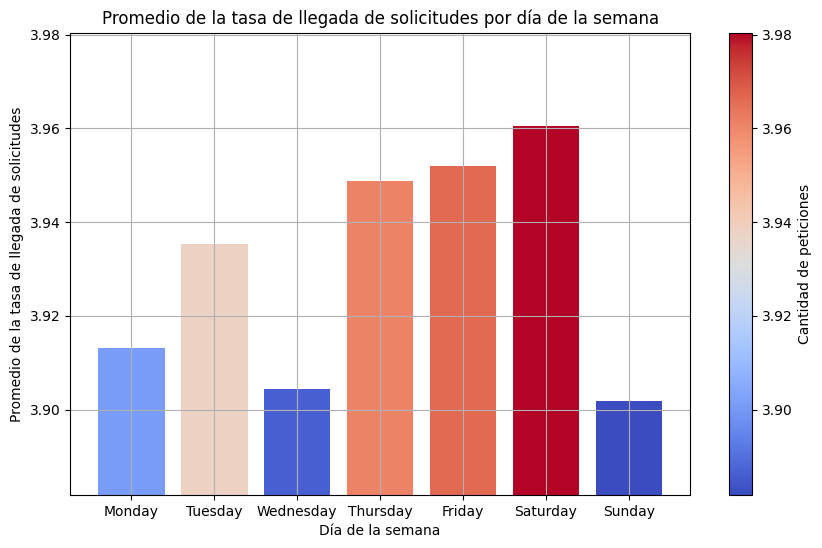

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Calcular la mediana de la tasa de llegada de solicitudes para cada día de la semana
mean_request_rate_by_day = df.groupby('Day')['Arrival_Rate'].mean()

# Definir el orden de los días de la semana
dias_ordenados = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Reordenar los datos de la mediana de acuerdo al orden de los días de la semana
mean_request_rate_by_day = mean_request_rate_by_day.reindex(dias_ordenados)

# Definir una escala de colores que vaya de azul a rojo, basada en los valores de la altura de las barras
colors = plt.cm.coolwarm((mean_request_rate_by_day - mean_request_rate_by_day.min()) / (mean_request_rate_by_day.max() - mean_request_rate_by_day.min()))

# Crear el gráfico de barras con colores graduales
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(np.arange(len(dias_ordenados)), mean_request_rate_by_day.values, color=colors)

# Añadir título y etiquetas
ax.set_title('Promedio de la tasa de llegada de solicitudes por día de la semana')
ax.set_xlabel('Día de la semana')
ax.set_ylabel('Promedio de la tasa de llegada de solicitudes')
ax.set_xticks(np.arange(len(dias_ordenados)))
ax.set_xticklabels(dias_ordenados)
ax.grid(True)

# Establecer los límites del eje según el rango de los datos en el eje y
min_limit = mean_request_rate_by_day.min() - 0.02
max_limit = mean_request_rate_by_day.max() + 0.02
plt.ylim(min_limit, max_limit)

# Añadir una barra de colores como leyenda en el eje y
sm = plt.cm.ScalarMappable(cmap=plt.cm.coolwarm, norm=plt.Normalize(vmin=min_limit, vmax=max_limit))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Cantidad de peticiones')

plt.show()


##### ¿Cuál es el promedio de la tasa de llegada de solicitudes para cada mes del año?

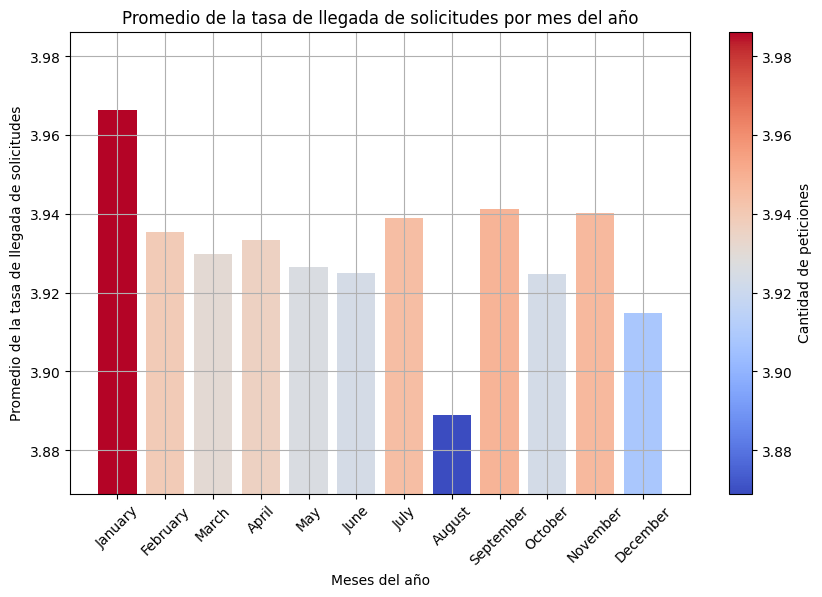

In [12]:
import matplotlib.pyplot as plt
import numpy as np

df2 = df.iloc[0:103682] #Vamos a tomar los registros sólo del primer año para hacer el gráfico

# Calcular la mediana de la tasa de llegada de solicitudes para cada día de la semana
mean_request_rate_by_day = df.groupby('Month')['Arrival_Rate'].mean()

# Definir el orden de los días de la semana
meses_ordenados = meses = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

# Reordenar los datos de la mediana de acuerdo al orden de los días de la semana
mean_request_rate_by_day = mean_request_rate_by_day.reindex(meses_ordenados)

# Definir una escala de colores que vaya de azul a rojo, basada en los valores de la altura de las barras
colors = plt.cm.coolwarm((mean_request_rate_by_day - mean_request_rate_by_day.min()) / (mean_request_rate_by_day.max() - mean_request_rate_by_day.min()))

# Crear el gráfico de barras con colores graduales
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(np.arange(len(meses_ordenados)), mean_request_rate_by_day.values, color=colors)

# Añadir título y etiquetas
ax.set_title('Promedio de la tasa de llegada de solicitudes por mes del año')
ax.set_xlabel('Meses del año')
ax.set_ylabel('Promedio de la tasa de llegada de solicitudes')
ax.set_xticks(np.arange(len(meses_ordenados)))
ax.set_xticklabels(meses_ordenados, rotation=45)
ax.grid(True)

# Establecer los límites del eje según el rango de los datos en el eje y
min_limit = mean_request_rate_by_day.min() - 0.02
max_limit = mean_request_rate_by_day.max() + 0.02
plt.ylim(min_limit, max_limit)

# Añadir una barra de colores como leyenda en el eje y
sm = plt.cm.ScalarMappable(cmap=plt.cm.coolwarm, norm=plt.Normalize(vmin=min_limit, vmax=max_limit))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Cantidad de peticiones')

plt.show()

#### Distribución Gamma y cálculo de probabilidades

2. Parámetros de la distribución gamma ajustada:
+-------------+--------------+
| Parameter   |        Value |
+=============+==============+
| Shape       |  1.28632     |
+-------------+--------------+
| Loc         | -0.000102199 |
+-------------+--------------+
| Scale       |  3.05596     |
+-------------+--------------+


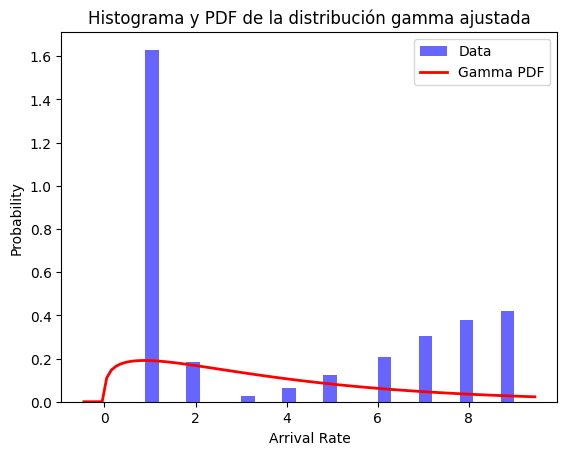

3. Probabilidad de recibir más de 8 solicitudes: 11.64%
4. Probabilidad de que la tasa de llegada supere 15 solicitudes/minuto: 1.36%
5. Probabilidad de superar la capacidad máxima de procesamiento del servidor: 0.06%


In [19]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gamma
import numpy as np
from tabulate import tabulate

def ajustar_distribucion_gamma(datos):
    """
    Ajusta una distribución gamma a los datos.

    Parámetros:
        datos (pandas.Series): La serie de datos para ajustar la distribución gamma.

    Retorna:
        tuple: Los parámetros de la distribución gamma ajustada (shape, loc, scale).
    """
    return gamma.fit(datos)

def plotear_histograma_y_pdf(datos, shape, loc, scale):
    """
    Plotea el histograma de los datos junto con la PDF de la distribución gamma ajustada.

    Parámetros:
        datos (pandas.Series): La serie de datos para plotear.
        shape (float): Parámetro de forma de la distribución gamma.
        loc (float): Parámetro de locación de la distribución gamma.
        scale (float): Parámetro de escala de la distribución gamma.
    """
    plt.hist(datos, bins=30, density=True, alpha=0.6, color='b', label='Data')
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = gamma.pdf(x, shape, loc, scale)
    plt.plot(x, p, linewidth=2, label='Gamma PDF',color='red')
    plt.legend()
    plt.xlabel('Arrival Rate')
    plt.ylabel('Probability')
    plt.title('Histograma y PDF de la distribución gamma ajustada')
    plt.show()

def calcular_probabilidad_mas_solicitudes(dato_umbral, shape, loc, scale):
    """
    Calcula la probabilidad de recibir más de un cierto número de solicitudes.

    Parámetros:
        dato_umbral (float): El umbral de solicitudes.
        shape (float): Parámetro de forma de la distribución gamma.
        loc (float): Parámetro de locación de la distribución gamma.
        scale (float): Parámetro de escala de la distribución gamma.

    Retorna:
        float: La probabilidad de recibir más de `dato_umbral` solicitudes.
    """
    return 1 - gamma.cdf(dato_umbral, shape, loc, scale)


# Ajuste de la distribución gamma
shape, loc, scale = ajustar_distribucion_gamma(df['Arrival_Rate'])
print("2. Parámetros de la distribución gamma ajustada:")
print(tabulate([['Shape', shape], ['Loc', loc], ['Scale', scale]], headers=['Parameter', 'Value'], tablefmt='grid'))

# Plotear el histograma junto con la PDF de la distribución gamma ajustada
plotear_histograma_y_pdf(df['Arrival_Rate'], shape, loc, scale)

# Probabilidad de que el servidor reciba más de 8 solicitudes durante el próximo intervalo
prob_c = calcular_probabilidad_mas_solicitudes(8, shape, loc, scale)
print("3. Probabilidad de recibir más de 8 solicitudes: {:.2f}%".format(prob_c*100))

# Probabilidad de que la tasa de llegada supere un umbral crítico de 15 solicitudes por minuto en el próximo intervalo
prob_d = calcular_probabilidad_mas_solicitudes(15, shape, loc, scale)
print("4. Probabilidad de que la tasa de llegada supere 15 solicitudes/minuto: {:.2f}%".format(prob_d*100))

# Probabilidad de superar la capacidad máxima de procesamiento del servidor (25 solicitudes por intervalo) en el siguiente intervalo
prob_e = calcular_probabilidad_mas_solicitudes(25, shape, loc, scale)
print("5. Probabilidad de superar la capacidad máxima de procesamiento del servidor: {:.2f}%".format(prob_e*100))
